In [5]:
!pip install -q tinkoff-investments

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from config import *
from datetime import timedelta, datetime
from tinkoff.invest import Client, CandleInterval, InstrumentStatus, InstrumentRequest
from tinkoff.invest.retrying.settings import RetryClientSettings
from tinkoff.invest.retrying.sync.client import RetryingClient
from tinkoff.invest.utils import now
from tinkoff.invest.services import InstrumentsService, MarketDataService

sns.set(style="darkgrid", font_scale=1.4)

In [7]:
retry_settings = RetryClientSettings(use_retry=True, max_retry_attempt=2)

def get_price_from_q(q):
    return q.units + q.nano * 0.000000001

def get_figi(ticker):
    with Client(TOKEN) as cl:
        instruments: InstrumentsService = cl.instruments
        market_data: MarketDataService = cl.market_data

        l = []
        for method in ['shares', 'bonds', 'etfs']:
            for item in getattr(instruments, method)().instruments:
                l.append({
                    'ticker': item.ticker,
                    'figi': item.figi,
                    'type': method,
                    'name': item.name,
                })

        df = pd.DataFrame(l)

        df = df[df['ticker'] == ticker]
        if df.empty:
            return None

        return df['figi'].iloc[0]

def get_candles_data(ticker, tf, date_from, date_to):
    timeframe_config = {
        '1MIN': CandleInterval.CANDLE_INTERVAL_1_MIN,
        '5MIN': CandleInterval.CANDLE_INTERVAL_5_MIN,
        '15MIN': CandleInterval.CANDLE_INTERVAL_15_MIN,
        '1HOUR': CandleInterval.CANDLE_INTERVAL_HOUR,
        '1DAY': CandleInterval.CANDLE_INTERVAL_DAY,
    }

    timeframe = timeframe_config[tf]

    figi = get_figi(ticker)

    data = {
        'open': [],
        'high': [],
        'low': [],
        'close': [],
        'volume': [],
        'time': [],
    }

    with RetryingClient(TOKEN, settings=retry_settings) as client:
        for candle in client.get_all_candles(
                figi=figi,
                from_=date_from,
                to=date_to,
                interval=timeframe,
        ):
            data['open'].append(get_price_from_q(candle.open))
            data['high'].append(get_price_from_q(candle.high))
            data['low'].append(get_price_from_q(candle.low))
            data['close'].append(get_price_from_q(candle.close))
            data['volume'].append(candle.volume)
            data['time'].append(candle.time)

    df = pd.DataFrame(data)

    for row in df.itertuples():
        df.loc[row.Index, 'time'] = row.time + timedelta(hours=3)

    return df

In [32]:
tcsg_data = get_candles_data(
    ticker='TCSG',
    tf='1DAY',
    date_from=now() - timedelta(days=180),
    date_to=now()
)

tcsg_data

,open,high,low,close,volume,time
0,3650.0,3780.0,3644.0,3762.0,807731,2023-09-04 03:00:00+00:00
1,3758.5,3809.5,3705.0,3741.0,762947,2023-09-05 03:00:00+00:00
2,3741.0,3741.0,3622.0,3644.5,648704,2023-09-06 03:00:00+00:00
3,3652.5,3660.0,3503.0,3539.5,758542,2023-09-07 03:00:00+00:00
4,3545.0,3566.5,3456.5,3493.0,420457,2023-09-08 03:00:00+00:00
...,...,...,...,...,...,...
112,3145.0,3145.5,3060.0,3066.0,472294,2024-02-09 03:00:00+00:00
113,3070.0,3105.0,2980.0,3056.0,940555,2024-02-12 03:00:00+00:00
114,3063.0,3124.0,3021.0,3109.5,407167,2024-02-13 03:00:00+00:00
115,3109.5,3150.0,3075.0,3103.0,417472,2024-02-14 03:00:00+00:00


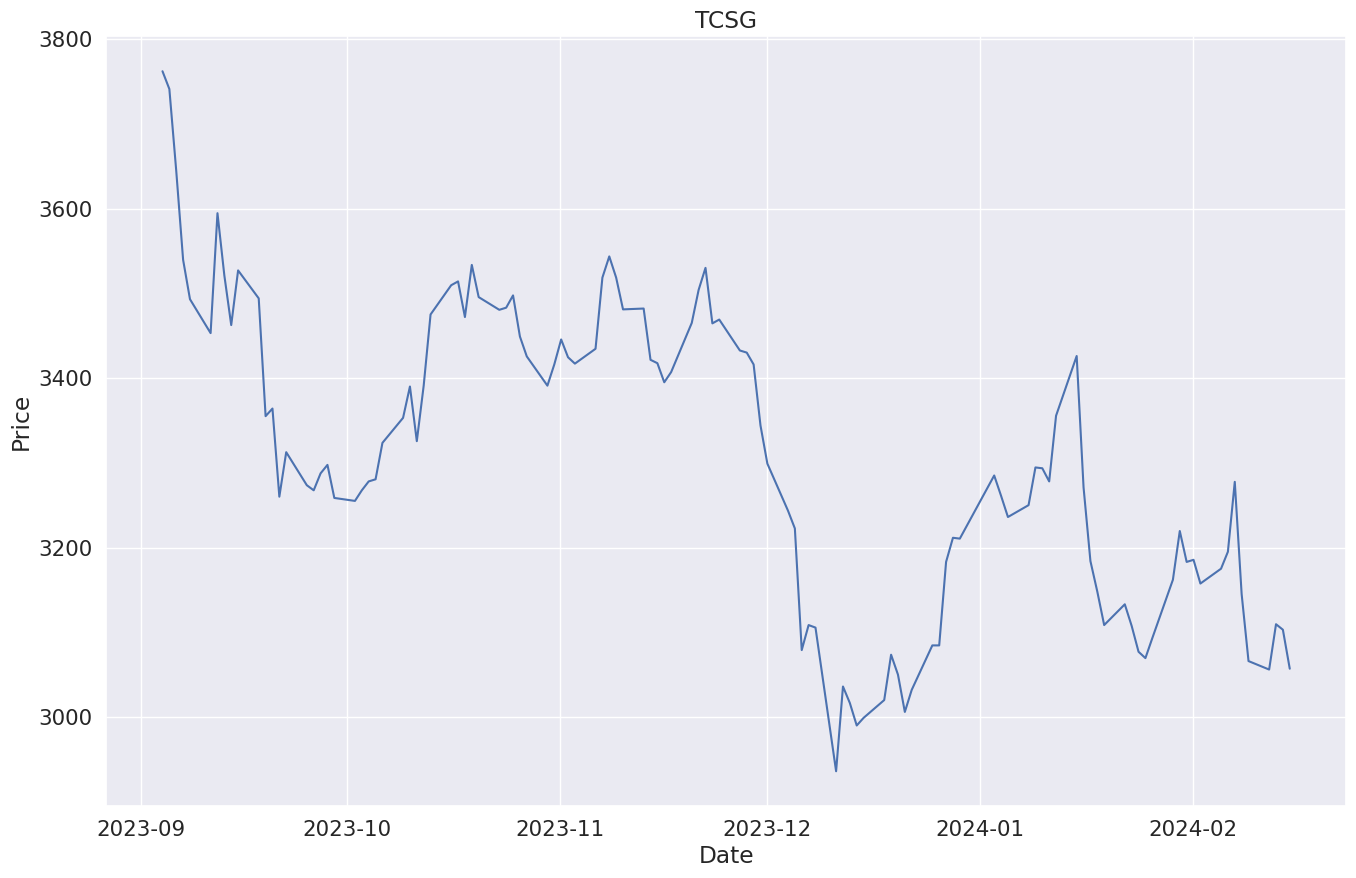

In [30]:
plt.figure(figsize=(16, 10))
plt.plot(tcsg_data['time'], tcsg_data['close'])
plt.title('TCSG')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()